# Chap8 SVM(2)

## 1. 二分类的SVC的进阶

### 1.1 参数C的理解进阶

针对线性不可分的数据，通过设置软间隔，允许一小部分的数据产生训练误差，我们就不能单纯地寻求最大边际了。因此，我们引入松弛系数$\zeta$和**松弛系数$C$的系数C**作为一个惩罚项，来惩罚我们对最大边际的追求
- 利用参数C的取值进行设定，C越大软间隔越大，模型更加准确，但是训练时间较长



### 1.2 二分类SVC的样本不均衡

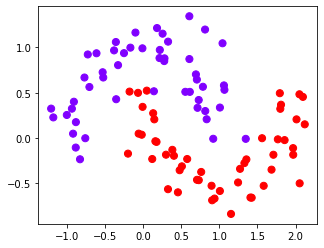

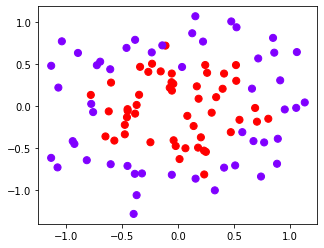

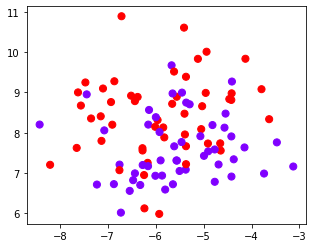

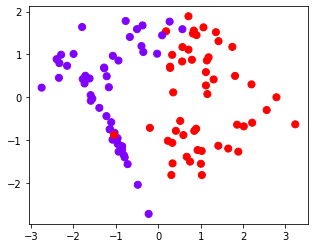

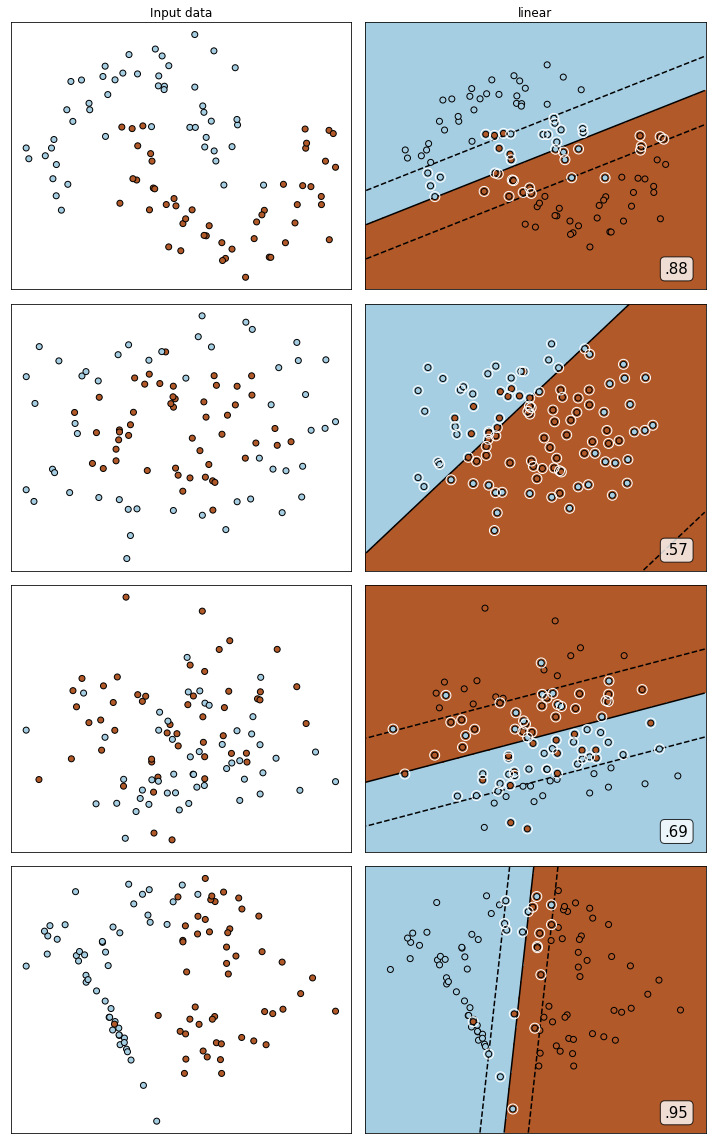

In [1]:
#————————————————————————————chap7中关于4种数据的SVM的图形表示代码————————————————————————————
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import svm
from sklearn.datasets import make_circles, make_moons, make_blobs,make_classification


# 制作4种数据
n_samples = 100
datasets = [
    make_moons(n_samples=n_samples, noise=0.2, random_state=0),
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
    make_blobs(n_samples=n_samples, centers=2, random_state=5),
    make_classification(n_samples=n_samples,n_features =
    2,n_informative=2,n_redundant=0, random_state=5)
]

Kernel = ["linear"]
#四个数据集分别是什么样子呢？
for X,Y in datasets:
    plt.figure(figsize=(5,4))
    plt.scatter(X[:,0],X[:,1],c=Y,s=50,cmap="rainbow")
nrows=len(datasets)
ncols=len(Kernel) + 1

fig, axes = plt.subplots(nrows, ncols,figsize=(10,16))

#第一层循环：在不同的数据集中循环
for ds_cnt, (X,Y) in enumerate(datasets):
    ax = axes[ds_cnt, 0]
    if ds_cnt == 0:
        ax.set_title("Input data")

    ax.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired,edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    
    for est_idx, kernel in enumerate(Kernel):
        ax = axes[ds_cnt, est_idx + 1]
        clf = svm.SVC(kernel=kernel, gamma=2).fit(X, Y)
        score = clf.score(X, Y)
        ax.scatter(X[:, 0], X[:, 1], c=Y
        ,zorder=10
        ,cmap=plt.cm.Paired,edgecolors='k')
        ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
        facecolors='none', zorder=10, edgecolors='white')
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
        ax.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
        ax.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
        levels=[-1, 0, 1])
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(kernel)

        ax.text(0.95, 0.06, ('%.2f' % score).lstrip('0')
                , size=15
                , bbox=dict(boxstyle='round', alpha=0.8, facecolor='white')
                #为分数添加一个白色的格子作为底色
                , transform=ax.transAxes #确定文字所对应的坐标轴，就是ax子图的坐标轴本身
                , horizontalalignment='right' #位于坐标轴的什么方向
        )
plt.tight_layout()
plt.show()

白色圈圈出的就是我们的支持向量，大家可以看到，所有在两条虚线超平面之间的点，和虚线超平面外，但属于另一个类别的点，都被我们认为是支持向量。并不是因为这些点都在我们的超平面上，而是因为我们的超平面由所有的这些点来决定，我们可以通过调节C来移动我们的超平面，让超平面过任何一个白色圈圈出的点

### 1.3 二分类SVC中的样本不均衡问题：重要参数class_weight

首先，分类模型天生会倾向于多数的类，让多数类更容易被判断正确，少数类被牺牲掉。其次，模型评估指标会失去意义。 我们调节样本均衡的参数：**SVC类中的class_weight和接口fit中可以设定的sample_weight**

- 一般两个参数中，我们只设定一个参数

**SVC的参数：class_weight**

可输入字典或者"balanced”，可不填，默认None 对SVC，将类i的参数C设置为class_weight [i] * C。如果没有给出具体的class_weight，则所有类都被假设为占有相同的权重1，模型会根据数据原本的状况去训练。

改善样本不均衡状况，输入`{"标签的值1"：权重1，"标签的值2"：权重2}`的字典，则参数C将会自动被设为：标签的值1的C：权重1 * C，标签的值2的C：权重2*C

**SVC的接口fit的参数：sample_weight**

- 输入每个样本的权重

数组，结构为 (n_samples, )，必须对应输入fit中的特征矩阵的每个样本每个样本在fit时的权重，让权重 * 每个样本对应的C值来迫使分类器强调设定的权重更大的样本。通常，较大的权重加在少数类的样本上，以迫使模型向着少数类的方向建模


我们接下来就来看看如何使用这个参数。首先，我们来自建一组样本不平衡的数据集。我们在这组数据集上建两个SVC模型，一个设置有class_weight参数，一个不设置class_weight参数。我们对两个模型分别进行评估并画出他们的决策边界，以此来观察


1.导入需要的库和模块

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

2.创建样本不均衡的数据集

In [ ]:
class_1 = 500
class_2 = 50 # 类别二只有50个
centets = [[0.0,0.0],[2.0,2.0]]  # 设置两个类别的中心
clusters_std = [1.5,0.5]  # 设置两个类别的方差
X,y = make_blobs(n_samples=[class_1,class_2],centers=centets,cluster_std=clusters_std,random_state=0,shuffle=False)


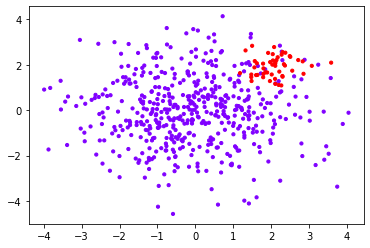

In [ ]:
# 查看数据的样子
plt.scatter(X[:,0],X[:,1],c=y,cmap='rainbow',s=10)
plt.show()

# 红色点为少数类

3.在数据集上分别建模

建立两个模型进行对比
- 不设置 class_weight
- 设置 class_weight

In [ ]:
#————————————————————————————不设置class_weight————————————————————————————

clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(X, y)
clf.score(X,y)

0.9418181818181818

In [ ]:
#————————————————————————————设置class_weight————————————————————————————

wclf = svm.SVC(kernel='linear', class_weight={1:10})
wclf.fit(X, y)
wclf.score(X,y)


# 样本均衡以后 准确率反而下降？？

0.9127272727272727

4.绘制决策边界

- 建立网格
- contour()

利用Contour函数绘制等高线，来绘制去决策边界$w*x+b=0$

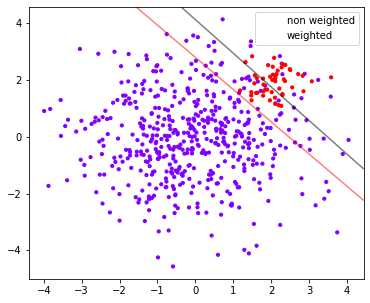

In [ ]:
# 首先要有数据分布
plt.figure(figsize=(6,5))
plt.scatter(X[:,0],X[:,1],c=y,cmap='rainbow',s=10)
ax = plt.gca()

#绘制决策边界的第一步：要有网格

xlim = ax.get_xlim()  # 获取x轴的取值范围
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

#第二步：找出我们的样本点到决策边界的距离
Z_clf = clf.decision_function(xy).reshape(XX.shape)
a = ax.contour(XX, YY, Z_clf, colors='black', levels=[0], alpha=0.5, linestyles=['-'])

Z_wclf = wclf.decision_function(xy).reshape(XX.shape)
b = ax.contour(XX, YY, Z_wclf, colors='red', levels=[0], alpha=0.5, linestyles=['-'])

#第三步：画图例
plt.legend([a.collections[0], b.collections[0]], ["non weighted", "weighted"],loc="upper right")
plt.show()

样本均衡前，少数类分类正确的较少。样本均衡以后，反而把少数类分类的更好，但是多数类分类错误更多。

- 样本均衡 提高了对少数类的分类效果

In [ ]:
a.collections #调用这个等高线对象中画的所有线，返回一个惰性对象


<a list of 1 PathCollection objects>

In [ ]:
#用[*]把它打开试试看
[*a.collections] #返回了一个linecollection对象，其实就是我们等高线里所有的线的列表


In [ ]:
#现在我们只有一条线，所以我们可以使用索引0来锁定这个对象
a.collections[0]


## 2.SVC的模型评估指标

我们往往在寻找**捕获少数类的能力和将多数类判错后需要付出的成本**的平衡。如果一个模型在能够尽量捕获少数类的情况下，还能够尽量对多数类判断正确，则这个模型就非常优秀了。为了评估这样的能力，我们将引入新的模型评估指标：混淆矩阵和ROC曲线来帮助我们

### 2.1 混淆矩阵（Confusion Matrix）

混淆矩阵是二分类问题的多维衡量指标体系，在样本不平衡时极其有用。

- True Positive（TP）：真正类
- False Negative（FN）：假负类
- False Positive（FP）：假正类
- True Negative（TN）：真负类

#### 2.1.1 模型整体效果：准确率
 
表示模型的精度，即模型识别正确的个数/样本的总个数。一般情况下，模型的精度越高，说明模型的效果越好。

$$Accuracy = (TP+TN)/(TP+FN+FP+TN)$$



#### 2.1.2 捕捉少数类的艺术：精确度，召回率和F1 score

>**精确度or查准率（Precision）**
>
>- 每一次将多数类判断错误的成本非常高昂的时候，我们会追求高精确度
>
>表示在模型识别为正类的样本中，真正为正类的样本所占的比例。一般情况下，查准率越高，说明模型的效果越好。
>
>$$Precision = TP/(TP+FP)$$

 

>**召回率（Recall）**
>
>- 如果我们希望不计一切代价，找出少数类，那我们就会追求高召回率.又称为查全率，召回率表现出在实际正样本中，分类器能预测出多少。
>
>表示的是，模型正确识别出为正类的样本的数量占总的正类样本数量的比值。一般情况下，Recall越高，说明有更多的正类样本被模型预测正确，模型的效果越好。
>
>$$Recall = TP/(TP+FN)$$
>召回率和精确度是此消彼长的，两者之间的平衡代表了**捕捉少数类的需求和尽量不要误伤多数类**的需求的平衡


>**F1-measure**
>
>越接近1越好，同时衡量了查准和查全
>
>$$F-score = \frac{2PR}{P+R}$$


In [ ]:
y[y == clf.predict(X)]  # 真实值等于预测值的全部样本

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
(y[y == clf.predict(X)] == 1).sum()
# 预测正确 且是1类的样本一共有30个

30

In [ ]:
#所有判断正确并确实为1的样本 / 所有被判断为1的样本
# y[y == clf.predict(X)]==1 预测正确且 是1类的全部样本
#对于没有class_weight，没有做样本平衡的灰色决策边界来说：
(y[y == clf.predict(X)] == 1).sum()/(clf.predict(X) == 1).sum()


0.7142857142857143

In [ ]:
#对于有class_weight，做了样本平衡的红色决策边界来说：
print((y[y == wclf.predict(X)] == 1).sum())   
# 样本平衡以后 预测正确且是1类的样本有50个

(y[y == wclf.predict(X)] == 1).sum()/(wclf.predict(X) == 1).sum()

# 样本均衡以后，精确度反而下降了

50


0.5102040816326531

#### 2.1.3 判错多数类的考量：特异度与假正率

$$Specificity = \frac{TN}{FN+TN}$$

表示所有真实为0的样本中，被正确预测为0的样本所占的比例。在支持向量机中，可以形象地表示为，决策边界下方的点占所有紫色点的比例

In [ ]:
#所有被正确预测为0的样本 / 所有的0样本
#对于没有class_weight，没有做样本平衡的灰色决策边界来说：
(y[y == clf.predict(X)] == 0).sum()/(y == 0).sum()


0.976

In [ ]:
#对于有class_weight，做了样本平衡的红色决策边界来说：
(y[y == wclf.predict(X)] == 0).sum()/(y == 0).sum()

0.904

#### 2.1.4 sklearn中的混淆矩阵

- `sklearn.metrics.confusion_matrix` 混淆矩阵
- `sklearn.metrics.accuracy_score` 准确率accuracy
- `sklearn.metrics.precision_score` 精确度precision
- `sklearn.metrics.recall_score` 召回率recall
- `sklearn.metrics.precision_recall_curve` 精确度-召回率平衡曲线
- `sklearn.metrics.f1_score F1 measure`

### 2.2 ROC曲线以及其相关问题

衡量模型在尽量捕捉少数类的时候，误伤多数类的情况如何变化，这就是我们的ROC曲线衡量的平衡

#### 2.2.1 概率(probability)与阈值(threshold)

1.新建数据集

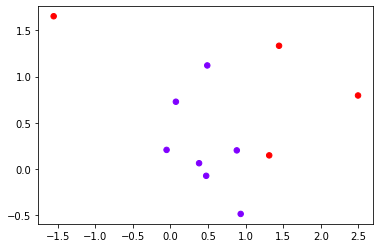

In [ ]:
# 二分类的数据 数据量较少

class_1_ = 7
class_2_ = 4
centers_ = [[0.0, 0.0], [1,1]]
clusters_std = [0.5, 1]
X_, y_ = make_blobs(n_samples=[class_1_, class_2_],
                    centers=centers_,
                    cluster_std=clusters_std,
                    random_state=0, shuffle=False)
                    
plt.scatter(X_[:, 0], X_[:, 1], c=y_, cmap="rainbow",s=30)

2.建模，调用概率

In [ ]:
from sklearn.linear_model import LogisticRegression as LogiR

clf_lo = LogiR().fit(X_,y_)
prob = clf_lo.predict_proba(X_)
prob


array([[0.69461879, 0.30538121],
       [0.5109308 , 0.4890692 ],
       [0.82003826, 0.17996174],
       [0.78564706, 0.21435294],
       [0.77738721, 0.22261279],
       [0.65663421, 0.34336579],
       [0.76858638, 0.23141362],
       [0.34917129, 0.65082871],
       [0.36618382, 0.63381618],
       [0.66327186, 0.33672814],
       [0.6075288 , 0.3924712 ]])

In [ ]:
#将样本和概率放到一个DataFrame中
import pandas as pd
prob = pd.DataFrame(prob)
prob.columns = ["0","1"]
prob

,0,1
0,0.694619,0.305381
1,0.510931,0.489069
2,0.820038,0.179962
3,0.785647,0.214353
4,0.777387,0.222613
5,0.656634,0.343366
6,0.768586,0.231414
7,0.349171,0.650829
8,0.366184,0.633816
9,0.663272,0.336728


3.使用阈值0.5，大于0.5的样本被预测为1，小于0.5的样本被预测为0


In [ ]:
for i in range(prob.shape[0]):
    if prob.loc[i,'1'] > 0.5:
        prob.loc[i,'pred'] = 1
    else:
        prob.loc[i,'pred'] = 0

prob


,0,1,pred
0,0.694619,0.305381,0.0
1,0.510931,0.489069,0.0
2,0.820038,0.179962,0.0
3,0.785647,0.214353,0.0
4,0.777387,0.222613,0.0
5,0.656634,0.343366,0.0
6,0.768586,0.231414,0.0
7,0.349171,0.650829,1.0
8,0.366184,0.633816,1.0
9,0.663272,0.336728,0.0


In [ ]:
prob["y_true"] = y_
prob = prob.sort_values(by="1",ascending=False)   # 根据1的概率进行排序 降序
prob

,0,1,pred,y_true
7,0.349171,0.650829,1.0,1
8,0.366184,0.633816,1.0,1
1,0.510931,0.489069,0.0,0
10,0.607529,0.392471,0.0,1
5,0.656634,0.343366,0.0,0
9,0.663272,0.336728,0.0,1
0,0.694619,0.305381,0.0,0
6,0.768586,0.231414,0.0,0
4,0.777387,0.222613,0.0,0
3,0.785647,0.214353,0.0,0


4.使用混淆矩阵查看结果

- 参数都是 真实值 预测值 labels(必须把少数类放在前面)

In [ ]:
from sklearn.metrics import confusion_matrix as CM, precision_score as P ,recall_score as R

In [ ]:
CM(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])
# 返回了混淆矩阵

array([[2, 2],
       [0, 7]], dtype=int64)

In [ ]:
P(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])

1.0

In [ ]:
R(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])

0.5

5.假如我们使用0.4作为阈值

In [ ]:
#————————————————————————————将0.4设置为阈值————————————————————————————
for i in range(prob.shape[0]):
    if prob.loc[i,"1"] > 0.4:
        prob.loc[i,"pred"] = 1
    else:
        prob.loc[i,"pred"] = 0

cm = CM(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])
p = P(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])
r = R(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])
print(cm)
print(p,r)

# 注意，降低或者升高阈值并不一定能够让模型的效果变好，一切都基于我们要追求怎样的模型效果

[[2 2]
 [1 6]]
0.6666666666666666 0.5


通常来说，降低阈值能够升高Recall

但是注意，并不是升高阈值，就一定能够增加或者减少Recall，一切要根据数据的实际分布来进行判断


#### 2.2.2 SVM实现概率预测：重要参数probability，接口predict_proba以及decision_function


- `decision_function`返回的值 SVM中的置信度（confidence）
  - 二分类中是 生成的距离 每个点到决策边界的距离
  
- `probability `默认为FAlSE 
  - 尽量不要使用，大型数据中严重影响计算速度
  - 是否启用概率估计。进行必须在调用fit之前启用它，启用此功能会减慢SVM的运算速度。
  - 设置为True则会启动，启用之后，SVC的接口predict_proba和predict_log_proba将生效
- 接口`.predict_proba(X)` # 生成了各类标签下的概率

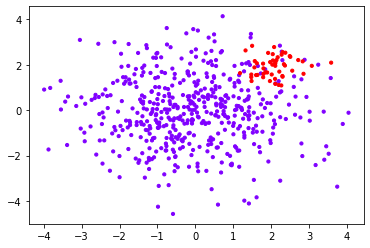

In [ ]:
#使用最初的X和y，样本不均衡的这个模型
class_1 = 500 #类别1有500个样本
class_2 = 50 #类别2只有50个
centers = [[0.0, 0.0], [2.0, 2.0]] #设定两个类别的中心
clusters_std = [1.5, 0.5] #设定两个类别的方差，通常来说，样本量比较大的类别会更加松散
X, y = make_blobs(n_samples=[class_1, class_2],
                    centers=centers,
                    cluster_std=clusters_std,
                    random_state=0, shuffle=False)
                    
#看看数据集长什么样
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="rainbow",s=10)
#其中红色点是少数类，紫色点是多数类


In [ ]:
clf_proba = svm.SVC(kernel="linear",C=1.0,probability=True).fit(X,y)


In [ ]:
clf_proba.predict_proba(X) # 生成了各类标签下的概率


array([[0.68303834, 0.31696166],
       [0.26251951, 0.73748049],
       [0.96148866, 0.03851134],
       ...,
       [0.15587118, 0.84412882],
       [0.35500696, 0.64499304],
       [0.31474527, 0.68525473]])

In [ ]:
clf_proba.predict_proba(X).shape

(550, 2)

In [ ]:
clf_proba.decision_function(X)
# 二分类中是 生成的距离 每个点到决策边界的距离

array([ -0.39182241,   0.95617053,  -2.24996184,  -2.63659269,
        -3.65243197,  -1.67311996,  -2.56396417,  -2.80650393,
        -1.76184723,  -4.7948575 ,  -7.59061196,  -3.66174848,
        -2.2508023 ,  -4.27626526,   0.78571364,  -3.24751892,
        -8.57016271,  -4.45823747,  -0.14034183,  -5.20657114,
        -8.02181046,  -4.18420871,  -5.6222409 ,  -5.12602771,
        -7.22592707,  -5.07749638,  -6.72386021,  -3.4945225 ,
        -3.51475144,  -5.72941551,  -5.79160724,  -8.06232013,
        -4.36303857,  -6.25419679,  -5.59426696,  -2.60919281,
        -3.90887478,  -4.38754704,  -6.46432224,  -4.54279979,
        -4.78961735,  -5.53727469,   1.33920817,  -2.27766451,
        -4.39650854,  -2.97649872,  -2.26771979,  -2.40781748,
        -1.41638181,  -3.26142275,  -2.7712218 ,  -4.87288439,
        -3.2594128 ,  -5.91189118,   1.48676267,   0.5389064 ,
        -2.76188843,  -3.36126945,  -2.64697843,  -1.63635284,
        -5.04695135,  -1.59196902,  -5.5195418 ,  -2.10

#### 2.2.3 绘制SVM的ROC曲线

ROC是一条以不同阈值下的假正率FPR为横坐标，不同阈值下的召回率Recall为纵坐标的曲线。


ROC曲线通常都是凸型的。对于一条凸型ROC曲线来说，曲线越靠近左上角越好，越往下越糟糕，曲线如果在虚线的下方，则证明模型完全无法使用。

但是它也有可能是一条凹形的ROC曲线。对于一条凹型ROC曲线来说，应该越靠近右下角越好，凹形曲线代表模型的预测结果与真实情况完全相反，那也不算非常糟糕，只要我们手动将模型的结果逆转，就可以得到一条左上方的弧线了。

最糟糕的就是，曲线位于图像中间，和虚线非常靠近

In [ ]:
# 首先来看看如何从混淆矩阵中获取FPR和Recal
cm = CM(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])
cm

#FPR
cm[1,0]/cm[1,:].sum()

0.14285714285714285

In [ ]:
#  阈值 每一各阈值都对应一次循环，每次都要有个一混淆矩阵 假正率 Recall
# 利用np.linspace  中的参数 endpoint 不取到最大值

In [ ]:

#开始绘图
recall = []
FPR = []

probrange = np.linspace(clf_proba.predict_proba(X)[:,1].min(),
                        clf_proba.predict_proba(X)[:,1].max(),
                        num=50,
                        endpoint=False)


from sklearn.metrics import confusion_matrix as CM, recall_score as R
import matplotlib.pyplot as plot

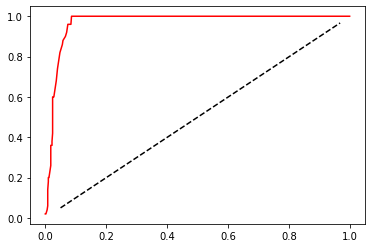

In [ ]:
for i in probrange:
    y_predict = []
    
    for j in range(X.shape[0]):
        if clf_proba.predict_proba(X)[j,1] > i:
            y_predict.append(1)
        else:
            y_predict.append(0)
            
    cm = CM(y,y_predict,labels=[1,0])
    recall.append(cm[0,0]/cm[0,:].sum())
    FPR.append(cm[1,0]/cm[1,:].sum())

recall.sort()
FPR.sort()

plt.plot(FPR,recall,c="red") # 横坐标为FPR 纵坐标为recall
plt.plot(probrange+0.05,probrange+0.05,c="black",linestyle="--")
plt.show()

#### 2.2.4 sklearn中的ROC曲线和AUC面积

- 计算ROC曲线的横坐标假正率FPR，纵坐标Recall和对应的阈值的类**sklearn.metrics.roc_curve**。
- 计算AUC面积的类**sklearn.metrics.roc_auc_score**

*sklearn.metrics.roc_curve (y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)*

- y_true : 数组，形状 = [n_samples]，真实标签
- y_score : 数组，形状 = [n_samples]，置信度分数，可以是正类样本的概率值，或置信度分数，或者
- decision_function返回的距离
- pos_label : 整数或者字符串, 默认None，表示被认为是正类样本的类别
- sample_weight : 形如 [n_samples]的类数组结构，可不填，表示样本的权重
- drop_intermediate : 默认True，如果设置为True，表示会舍弃一些ROC曲线上不显示的阈值点


*sklearn.metrics.roc_auc_score (y_true, y_score, average=’macro’, sample_weight=None, max_fpr=None)*

AUC面积的分数使用以上类来进行计算，输入的参数也比较简单，就是真实标签，和与roc_curve中一致的置信度分数或者概率值

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

FPR, recall, thresholds = roc_curve(y,clf_proba.decision_function(X), pos_label=1)

FPR


array([0.   , 0.   , 0.006, 0.006, 0.008, 0.008, 0.01 , 0.01 , 0.014,
       0.014, 0.018, 0.018, 0.022, 0.022, 0.024, 0.024, 0.028, 0.028,
       0.03 , 0.03 , 0.032, 0.032, 0.036, 0.036, 0.04 , 0.04 , 0.042,
       0.042, 0.044, 0.044, 0.05 , 0.05 , 0.054, 0.054, 0.058, 0.058,
       0.066, 0.066, 0.072, 0.072, 0.074, 0.074, 0.086, 0.086, 1.   ])

In [ ]:
recall


array([0.  , 0.02, 0.02, 0.06, 0.06, 0.16, 0.16, 0.2 , 0.2 , 0.22, 0.22,
       0.36, 0.36, 0.42, 0.42, 0.6 , 0.6 , 0.62, 0.62, 0.64, 0.64, 0.68,
       0.68, 0.7 , 0.7 , 0.74, 0.74, 0.76, 0.76, 0.82, 0.82, 0.84, 0.84,
       0.86, 0.86, 0.88, 0.88, 0.92, 0.92, 0.94, 0.94, 0.96, 0.96, 1.  ,
       1.  ])

In [ ]:
thresholds

array([  3.18236076,   2.18236076,   1.48676267,   1.35964325,
         1.33920817,   1.14038015,   1.13383091,   1.00003406,
         0.85085628,   0.84476439,   0.78571364,   0.60568093,
         0.5389064 ,   0.46718521,   0.44396046,   0.03907036,
        -0.07011269,  -0.10668727,  -0.1258212 ,  -0.13845693,
        -0.14034183,  -0.16790648,  -0.2040958 ,  -0.22137683,
        -0.24381463,  -0.26762451,  -0.34446784,  -0.3467975 ,
        -0.39182241,  -0.40676459,  -0.4589064 ,  -0.46310299,
        -0.49195707,  -0.5088941 ,  -0.53560561,  -0.55152081,
        -0.62628865,  -0.67580418,  -0.78127198,  -0.79874442,
        -0.88438995,  -0.91257798,  -1.01417607,  -1.08601917,
       -10.31959605])

In [ ]:
from sklearn.metrics import roc_auc_score as AUC

area = AUC(y,clf_proba.decision_function(X))

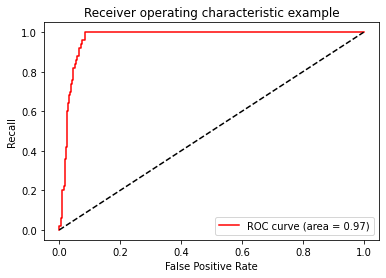

In [ ]:
plt.figure()
plt.plot(FPR, recall, color='red',label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# 设置横轴和纵轴的取值范围
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### 2.2.5 利用ROC曲线找出最佳阈值

模型在捕获少数类的能力变强的时候，尽量不误伤多数类，也就是说，随着recall的变大，FPR的大小越小越好。所以我们希望找到的最有点，其实是Recall和FPR差距最大的点。这个点，又叫做约登指数

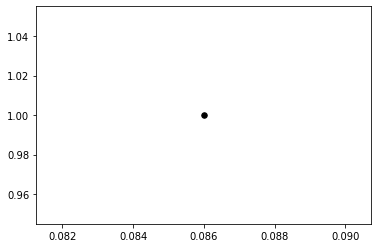

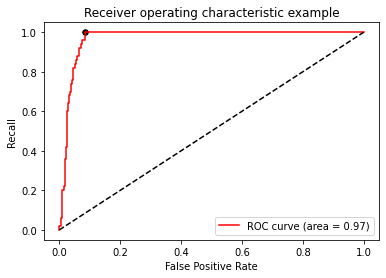

In [ ]:
maxindex = (recall - FPR).tolist().index(max(recall - FPR))   # index(max())  返回最大值的索引

thresholds[maxindex]
#我们可以在图像上来看看这个点在哪里
plt.scatter(FPR[maxindex],recall[maxindex],c="black",s=30)


#把上述代码放入这段代码中：
plt.figure()
plt.plot(FPR, recall, color='red',
label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.scatter(FPR[maxindex],recall[maxindex],c="black",s=30)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## 3.略

## 4.SVC真实数据案例：预测下雨

### 4.1 导库

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
weather = pd.read_csv('./DATASETS/chap8/weatherAUS5000.csv',index_col=0)
weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
0,2015-03-24,Adelaide,12.3,19.3,0.0,5.0,NaN,S,39.0,S,...,19.0,59.0,47.0,1022.2,1021.4,NaN,NaN,15.1,17.7,No
1,2011-07-12,Adelaide,7.9,11.4,0.0,1.0,0.5,N,20.0,NNE,...,7.0,70.0,59.0,1028.7,1025.7,NaN,NaN,8.4,11.3,No
2,2010-02-08,Adelaide,24.0,38.1,0.0,23.4,13.0,SE,39.0,NNE,...,19.0,36.0,24.0,1018.0,1016.0,NaN,NaN,32.4,37.4,No
3,2016-09-19,Adelaide,6.7,16.4,0.4,NaN,NaN,N,31.0,N,...,15.0,65.0,40.0,1014.4,1010.0,NaN,NaN,11.2,15.9,No
4,2014-03-05,Adelaide,16.7,24.8,0.0,6.6,11.7,S,37.0,S,...,24.0,61.0,48.0,1019.3,1018.9,NaN,NaN,20.8,23.7,No


In [4]:
#将特征矩阵和标签Y分开
X = weather.iloc[:,:-1]
Y = weather.iloc[:,-1]
X.shape


(5000, 21)

In [5]:
#探索数据类型
X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           5000 non-null   object 
 1   Location       5000 non-null   object 
 2   MinTemp        4979 non-null   float64
 3   MaxTemp        4987 non-null   float64
 4   Rainfall       4950 non-null   float64
 5   Evaporation    2841 non-null   float64
 6   Sunshine       2571 non-null   float64
 7   WindGustDir    4669 non-null   object 
 8   WindGustSpeed  4669 non-null   float64
 9   WindDir9am     4651 non-null   object 
 10  WindDir3pm     4887 non-null   object 
 11  WindSpeed9am   4949 non-null   float64
 12  WindSpeed3pm   4919 non-null   float64
 13  Humidity9am    4936 non-null   float64
 14  Humidity3pm    4880 non-null   float64
 15  Pressure9am    4506 non-null   float64
 16  Pressure3pm    4504 non-null   float64
 17  Cloud9am       3111 non-null   float64
 18  Cloud3pm

In [6]:
#探索缺失值
X.isnull().mean()


Date             0.0000
Location         0.0000
MinTemp          0.0042
MaxTemp          0.0026
Rainfall         0.0100
Evaporation      0.4318
Sunshine         0.4858
WindGustDir      0.0662
WindGustSpeed    0.0662
WindDir9am       0.0698
WindDir3pm       0.0226
WindSpeed9am     0.0102
WindSpeed3pm     0.0162
Humidity9am      0.0128
Humidity3pm      0.0240
Pressure9am      0.0988
Pressure3pm      0.0992
Cloud9am         0.3778
Cloud3pm         0.3976
Temp9am          0.0066
Temp3pm          0.0176
dtype: float64

In [7]:
#探索标签的分类
np.unique(Y)

array(['No', 'Yes'], dtype=object)

### 4.2 分集，优先探索标签

- 标签编码 `sklearn.preprocessing.LabelEncoder`
  - `LabelEncoder().fit(Ytrain)` 实例化+训练
  - `encorder.transform(Ytrain)` 得出结果
- 转换为csv文件 to_csv('')

In [8]:
#分训练集和测试集
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size=0.3,random_state=420)


In [9]:
#恢复索引
for i in [Xtrain, Xtest, Ytrain, Ytest]:
    i.index = range(i.shape[0])

Xtrain.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,2015-08-24,Katherine,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,17.0,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN
1,2016-12-10,Tuggeranong,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,7.0,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6
2,2010-04-18,Albany,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,17.0,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8
3,2009-11-26,Sale,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,11.0,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5
4,2014-04-25,Mildura,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4


In [10]:
# 轻微的样本不均衡
Ytrain.value_counts()

No     2704
Yes     796
Name: RainTomorrow, dtype: int64

In [11]:
Ytest.value_counts()

No     1157
Yes     343
Name: RainTomorrow, dtype: int64

In [12]:
# 将标签编码 
from sklearn.preprocessing import LabelEncoder  # 标签专用


In [13]:
encorder = LabelEncoder().fit(Ytrain)


In [14]:
Ytrain = pd.DataFrame(encorder.transform(Ytrain))


In [15]:
Ytest = pd.DataFrame(encorder.transform(Ytest))

# 测试集中出现了 训练集中没有出现过得标签列 就会报错

In [16]:
Ytrain

,0
0,0
1,0
2,0
3,1
4,0
...,...
3495,0
3496,1
3497,0
3498,0


In [17]:
Ytest.head()

,0
0,0
1,0
2,1
3,0
4,0


In [18]:
Ytrain.to_csv('Ytrain_save.csv')

### 4.3 探索特征，开始处理特征矩阵

- `describe()`
- `sort_values(by='列名')` 根据某一列的对数据进行排序
- `value_counts()` 计算每个取值的个数
- `split('-')` 根据-划分
- `apply(lambda x:表达式)`

#### 4.3.1 描述性统计与异常值

In [19]:
#描述性统计
Xtrain.describe([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.99]).T # 转置方便观看

# 量纲不统一


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,99%,max
MinTemp,3486.0,12.225645,6.396243,-6.5,-1.715,1.800,4.1,7.7,12.0,16.7,20.9,25.900,29.0
MaxTemp,3489.0,23.245543,7.201839,-3.7,8.888,12.840,14.5,18.0,22.5,28.4,33.0,40.400,46.4
Rainfall,3467.0,2.487049,7.949686,0.0,0.000,0.000,0.0,0.0,0.0,0.8,6.6,41.272,115.8
Evaporation,1983.0,5.619163,4.383098,0.0,0.400,0.800,1.4,2.6,4.8,7.4,10.2,20.600,56.0
Sunshine,1790.0,7.508659,3.805841,0.0,0.000,0.345,1.4,4.6,8.3,10.6,12.0,13.300,13.9
WindGustSpeed,3263.0,39.858413,13.219607,9.0,15.000,20.000,24.0,31.0,39.0,48.0,57.0,76.000,117.0
WindSpeed9am,3466.0,14.046163,8.670472,0.0,0.000,0.000,4.0,7.0,13.0,19.0,26.0,37.000,65.0
WindSpeed3pm,3437.0,18.553390,8.611818,0.0,2.000,6.000,7.0,13.0,19.0,24.0,30.0,43.000,65.0
Humidity9am,3459.0,69.069095,18.787698,2.0,18.000,35.000,45.0,57.0,70.0,83.0,94.0,100.000,100.0
Humidity3pm,3408.0,51.651995,20.697872,2.0,9.000,17.000,23.0,37.0,52.0,66.0,79.0,98.000,100.0


In [20]:
Xtest.describe([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,99%,max
MinTemp,1493.0,11.916812,6.375377,-8.5,-2.024,1.600,3.70,7.3,11.8,16.5,20.48,25.316,28.3
MaxTemp,1498.0,22.906809,6.986043,-0.8,9.134,13.000,14.50,17.8,22.4,27.8,32.60,38.303,45.1
Rainfall,1483.0,2.241807,7.988822,0.0,0.000,0.000,0.00,0.0,0.0,0.8,5.20,35.372,108.2
Evaporation,858.0,5.657809,4.105762,0.0,0.400,1.000,1.60,2.8,4.8,7.6,10.40,19.458,38.8
Sunshine,781.0,7.677465,3.862294,0.0,0.000,0.300,1.50,4.7,8.6,10.7,12.20,13.400,13.9
WindGustSpeed,1406.0,40.044097,14.027052,9.0,15.000,20.000,24.00,30.0,39.0,48.0,57.00,78.000,122.0
WindSpeed9am,1483.0,13.986514,9.124337,0.0,0.000,0.000,4.00,7.0,13.0,20.0,26.00,39.360,72.0
WindSpeed3pm,1482.0,18.601215,8.850446,0.0,2.000,6.000,7.00,13.0,19.0,24.0,31.00,43.000,56.0
Humidity9am,1477.0,68.688558,18.876448,4.0,20.000,36.000,44.00,57.0,69.0,82.0,95.00,100.000,100.0
Humidity3pm,1472.0,51.431386,20.459957,2.0,8.710,18.000,23.00,37.0,52.0,66.0,78.00,96.290,100.0


如果出现了异常值，首先要查看异常值出现的频率
- 如果异常值只出现了，多半是输入错误，直接删除异常值
- 如果异常值多次出现，和业务人员进行沟通，人为造成的错误异常值是没有用的
- 如果异常值占到10%以上，数据可能有问题  
  - 异常值替换成非异常当时无影响的量
    - 用0进行替换
    - 或者吧异常值变成缺失值 


#### 4.3.2 处理困难特征：日期



In [21]:
Xtrainc = Xtrain.copy()

Xtrainc.sort_values(by='Location')


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
2796,2015-03-24,Adelaide,12.3,19.3,0.0,5.0,NaN,S,39.0,S,...,13.0,19.0,59.0,47.0,1022.2,1021.4,NaN,NaN,15.1,17.7
2975,2012-08-17,Adelaide,7.8,13.2,17.6,0.8,NaN,SW,61.0,SW,...,20.0,28.0,76.0,47.0,1012.5,1014.7,NaN,NaN,8.3,12.5
775,2013-03-16,Adelaide,17.4,23.8,NaN,NaN,9.7,SSE,46.0,S,...,9.0,19.0,63.0,57.0,1019.9,1020.5,NaN,NaN,19.1,20.7
861,2011-07-12,Adelaide,7.9,11.4,0.0,1.0,0.5,N,20.0,NNE,...,7.0,7.0,70.0,59.0,1028.7,1025.7,NaN,NaN,8.4,11.3
2906,2015-08-24,Adelaide,9.2,14.3,0.0,NaN,NaN,SE,48.0,SE,...,17.0,19.0,64.0,42.0,1024.7,1024.1,NaN,NaN,9.9,13.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2223,2009-05-08,Woomera,9.2,20.6,0.0,5.2,10.4,ESE,37.0,SE,...,19.0,19.0,64.0,34.0,1030.5,1026.9,0.0,1.0,13.7,20.1
1984,2014-05-26,Woomera,15.5,23.6,0.0,24.0,NaN,NNW,43.0,NNE,...,9.0,26.0,49.0,37.0,1014.2,1010.3,7.0,7.0,18.0,21.5
1592,2012-01-10,Woomera,16.8,26.7,0.0,10.0,5.3,SW,46.0,S,...,20.0,22.0,52.0,33.0,1019.1,1016.8,4.0,6.0,18.3,24.9
2824,2015-11-03,Woomera,16.2,28.5,7.8,4.2,4.5,WSW,80.0,NE,...,26.0,50.0,76.0,53.0,1009.6,1006.8,6.0,7.0,20.5,26.2


In [22]:
Xtrain.iloc[:,0].value_counts()

#首先，日期不是独一无二的，日期有重复
#其次，在我们分训练集和测试集之后，日期也不是连续的，而是分散的
#某一年的某一天倾向于会下雨？或者倾向于不会下雨吗？
#不是日期影响了下雨与否，反而更多的是这一天的日照时间，湿度，温度等等这些因素影响了是否会下雨
#光看日期，其实感觉它对我们的判断并无直接影响
#如果我们把它当作连续型变量处理，那算法会人为它是一系列1~3000左右的数字，不会意识到这是日期


2015-10-12    6
2014-05-16    6
2015-07-03    6
2009-03-30    5
2016-09-07    5
             ..
2010-06-14    1
2013-12-01    1
2009-01-18    1
2014-11-24    1
2014-04-04    1
Name: Date, Length: 2141, dtype: int64

In [23]:
Xtrain.iloc[:,0].value_counts().count()
#如果我们把它当作分类型变量处理，类别太多，有2141类，如果换成数值型，会被直接当成连续型变量，如果做成哑变量，我们特征的维度会爆炸

2141

In [24]:
Xtrain["Rainfall"].head(20)


0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
6      0.0
7      0.2
8      0.0
9      0.2
10     1.0
11     0.0
12     0.2
13     0.0
14     0.0
15     3.0
16     0.2
17     0.0
18    35.2
19     0.0
Name: Rainfall, dtype: float64

In [25]:
# “Rainfall"，这是表示当前日期当前地区下的降雨量

Xtrain.loc[Xtrain["Rainfall"] >= 1,"RainToday"] = "Yes"
Xtrain.loc[Xtrain["Rainfall"] < 1,"RainToday"] = "No"
Xtrain.loc[Xtrain["Rainfall"] == np.nan,"RainToday"] = np.nan
Xtrain.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,2015-08-24,Katherine,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN,No
1,2016-12-10,Tuggeranong,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6,No
2,2010-04-18,Albany,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8,No
3,2009-11-26,Sale,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5,No
4,2014-04-25,Mildura,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4,No


In [26]:
Xtest.loc[Xtest["Rainfall"] >= 1,"RainToday"] = "Yes"
Xtest.loc[Xtest["Rainfall"] < 1,"RainToday"] = "No"
Xtest.loc[Xtest["Rainfall"] == np.nan,"RainToday"] = np.nan
Xtest.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,2016-01-23,NorahHead,22.0,27.8,25.2,NaN,NaN,SSW,57.0,S,...,37.0,91.0,86.0,1006.6,1008.1,NaN,NaN,26.2,23.1,Yes
1,2009-03-05,MountGambier,12.0,18.6,2.2,3.0,7.8,SW,52.0,SW,...,28.0,88.0,62.0,1020.2,1019.9,8.0,7.0,14.8,17.5,Yes
2,2010-03-05,MountGinini,9.1,13.3,NaN,NaN,NaN,NE,41.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-10-26,Wollongong,13.1,20.3,0.0,NaN,NaN,SW,33.0,W,...,24.0,40.0,51.0,1021.3,1019.5,NaN,NaN,16.8,19.6,No
4,2016-11-28,Sale,12.2,20.0,0.4,NaN,NaN,E,33.0,SW,...,19.0,92.0,69.0,1015.6,1013.2,8.0,4.0,13.6,19.0,No


In [27]:
Xtrain.loc[:,'RainToday']

0        No
1        No
2        No
3        No
4        No
       ... 
3495     No
3496    Yes
3497     No
3498     No
3499     No
Name: RainToday, Length: 3500, dtype: object

In [28]:
#————————————————————————————将日期转换为月份————————————————————————————

int(Xtrain.loc[0,'Date'].split('-')[1])  # 提取单个日期的月份

Xtrain["Date"] = Xtrain["Date"].apply(lambda x:int(x.split("-")[1]))
Xtrain['Date']



0        8
1       12
2        4
3       11
4        4
        ..
3495     9
3496     4
3497    11
3498     1
3499    11
Name: Date, Length: 3500, dtype: int64

In [29]:
Xtest["Date"] = Xtest["Date"].apply(lambda x:int(x.split("-")[1]))

Xtrain = Xtrain.rename(columns={"Date":"Month"})
Xtrain.head()


,Month,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8,Katherine,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN,No
1,12,Tuggeranong,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6,No
2,4,Albany,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8,No
3,11,Sale,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5,No
4,4,Mildura,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4,No


In [30]:
Xtest = Xtest.rename(columns={"Date":"Month"})
Xtest.head()

,Month,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,1,NorahHead,22.0,27.8,25.2,NaN,NaN,SSW,57.0,S,...,37.0,91.0,86.0,1006.6,1008.1,NaN,NaN,26.2,23.1,Yes
1,3,MountGambier,12.0,18.6,2.2,3.0,7.8,SW,52.0,SW,...,28.0,88.0,62.0,1020.2,1019.9,8.0,7.0,14.8,17.5,Yes
2,3,MountGinini,9.1,13.3,NaN,NaN,NaN,NE,41.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,Wollongong,13.1,20.3,0.0,NaN,NaN,SW,33.0,W,...,24.0,40.0,51.0,1021.3,1019.5,NaN,NaN,16.8,19.6,No
4,11,Sale,12.2,20.0,0.4,NaN,NaN,E,33.0,SW,...,19.0,92.0,69.0,1015.6,1013.2,8.0,4.0,13.6,19.0,No


#### 4.3.3 处理困难特征：地点

- re.sub(希望替换的值，希望被替换成的值，要操作的字符串)
- x.strip()是去掉空格的函数

In [31]:
Xtrain.loc[:,'Location'].unique

<bound method Series.unique of 0         Katherine
1       Tuggeranong
2            Albany
3              Sale
4           Mildura
           ...     
3495      NorahHead
3496     Wollongong
3497    Witchcliffe
3498       Watsonia
3499     PearceRAAF
Name: Location, Length: 3500, dtype: object>

In [32]:
cityll = pd.read_csv('./DATASETS/chap8/cityll.csv',index_col=0)
city_climate = pd.read_csv('./DATASETS/chap8/Cityclimate.csv')
cityll.head()



,City,Latitude,Longitude,Latitudedir,Longitudedir
0,Adelaide,34.9285°,138.6007°,"S,",E
1,Albany,35.0275°,117.8840°,"S,",E
2,Albury,36.0737°,146.9135°,"S,",E
3,Wodonga,36.1241°,146.8818°,"S,",E
4,AliceSprings,23.6980°,133.8807°,"S,",E


In [33]:
city_climate.head()

,City,Climate
0,Adelaide,Warm temperate
1,Albany,Mild temperate
2,Albury,"Hot dry summer, cool winter"
3,Wodonga,"Hot dry summer, cool winter"
4,AliceSprings,"Hot dry summer, warm winter"


In [34]:
#去掉度数符号
cityll["Latitudenum"] = cityll["Latitude"].apply(lambda x:float(x[:-1]))
cityll["Longitudenum"] = cityll["Longitude"].apply(lambda x:float(x[:-1]))
cityll.head()


,City,Latitude,Longitude,Latitudedir,Longitudedir,Latitudenum,Longitudenum
0,Adelaide,34.9285°,138.6007°,"S,",E,34.9285,138.6007
1,Albany,35.0275°,117.8840°,"S,",E,35.0275,117.8840
2,Albury,36.0737°,146.9135°,"S,",E,36.0737,146.9135
3,Wodonga,36.1241°,146.8818°,"S,",E,36.1241,146.8818
4,AliceSprings,23.6980°,133.8807°,"S,",E,23.6980,133.8807


In [35]:
#观察一下所有的经纬度方向都是一致的，全部是南纬，东经，因为澳大利亚在南半球，东半球
#所以经纬度的方向我们可以舍弃了
citylld = cityll.iloc[:,[0,5,6]]  # 只取出城市名称和经纬度
  

In [36]:
#将city_climate中的气候添加到我们的citylld中
citylld["climate"] = city_climate.iloc[:,-1]
citylld.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_17788\4034988345.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citylld["climate"] = city_climate.iloc[:,-1]


,City,Latitudenum,Longitudenum,climate
0,Adelaide,34.9285,138.6007,Warm temperate
1,Albany,35.0275,117.8840,Mild temperate
2,Albury,36.0737,146.9135,"Hot dry summer, cool winter"
3,Wodonga,36.1241,146.8818,"Hot dry summer, cool winter"
4,AliceSprings,23.6980,133.8807,"Hot dry summer, warm winter"


In [37]:
samplecity = pd.read_csv('./DATASETS/chap8/samplecity.csv',index_col=0)
samplecity.head()


,City,Latitude,Longitude,Latitudedir,Longitudedir
0,Canberra,35.2809°,149.1300°,"S,",E
1,Sydney,33.8688°,151.2093°,"S,",E
2,Perth,31.9505°,115.8605°,"S,",E
3,Darwin,12.4634°,130.8456°,"S,",E
4,Hobart,42.8821°,147.3272°,"S,",E


In [38]:
#我们对samplecity也执行同样的处理：去掉经纬度中度数的符号，并且舍弃我们的经纬度的方向
samplecity["Latitudenum"] = samplecity["Latitude"].apply(lambda x:float(x[:-1]))
samplecity["Longitudenum"] = samplecity["Longitude"].apply(lambda x:float(x[:-1]))
samplecityd = samplecity.iloc[:,[0,5,6]]
samplecityd.head()

,City,Latitudenum,Longitudenum
0,Canberra,35.2809,149.1300
1,Sydney,33.8688,151.2093
2,Perth,31.9505,115.8605
3,Darwin,12.4634,130.8456
4,Hobart,42.8821,147.3272


In [39]:
from math import radians, sin, cos, acos
citylld.loc[:,"slat"] = citylld.iloc[:,1].apply(lambda x : radians(x))
citylld.loc[:,"slon"] = citylld.iloc[:,2].apply(lambda x : radians(x))
samplecityd.loc[:,"elat"] = samplecityd.iloc[:,1].apply(lambda x : radians(x))
samplecityd.loc[:,"elon"] = samplecityd.iloc[:,2].apply(lambda x : radians(x))
samplecityd.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_17788\2754813741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citylld.loc[:,"slat"] = citylld.iloc[:,1].apply(lambda x : radians(x))
C:\Users\HP\AppData\Local\Temp\ipykernel_17788\2754813741.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citylld.loc[:,"slon"] = citylld.iloc[:,2].apply(lambda x : radians(x))
C:\Users\HP\AppData\Local\Temp\ipykernel_17788\2754813741.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,City,Latitudenum,Longitudenum,elat,elon
0,Canberra,35.2809,149.1300,0.615768,2.602810
1,Sydney,33.8688,151.2093,0.591122,2.639100
2,Perth,31.9505,115.8605,0.557641,2.022147
3,Darwin,12.4634,130.8456,0.217527,2.283687
4,Hobart,42.8821,147.3272,0.748434,2.571345


In [40]:
import sys

for i in range(samplecityd.shape[0]):
    slat = citylld.loc[:,"slat"]
    slon = citylld.loc[:,"slon"]
    elat = samplecityd.loc[i,"elat"]
    elon = samplecityd.loc[i,"elon"]
    dist = 6371.01 * np.arccos(np.sin(slat)*np.sin(elat) + np.cos(slat)*np.cos(elat)*np.cos(slon.values - elon))

    city_index = np.argsort(dist)[0]
    #每次计算后，取距离最近的城市，然后将最近的城市和城市对应的气候都匹配到samplecityd中
    samplecityd.loc[i,"closest_city"] = citylld.loc[city_index,"City"]
    samplecityd.loc[i,"climate"] = citylld.loc[city_index,"climate"]


C:\Users\HP\AppData\Local\Temp\ipykernel_17788\2162208838.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samplecityd.loc[i,"closest_city"] = citylld.loc[city_index,"City"]
c:\Users\HP\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [41]:
#查看最后的结果，需要检查城市匹配是否基本正确
samplecityd.head()


,City,Latitudenum,Longitudenum,elat,elon,closest_city,climate
0,Canberra,35.2809,149.1300,0.615768,2.602810,Canberra,Cool temperate
1,Sydney,33.8688,151.2093,0.591122,2.639100,Sydney,Warm temperate
2,Perth,31.9505,115.8605,0.557641,2.022147,Perth,Warm temperate
3,Darwin,12.4634,130.8456,0.217527,2.283687,Darwin,"High humidity summer, warm winter"
4,Hobart,42.8821,147.3272,0.748434,2.571345,Hobart,Cool temperate


In [42]:
#查看气候的分布
samplecityd["climate"].value_counts()


Warm temperate                       15
Mild temperate                       10
Cool temperate                        9
Hot dry summer, cool winter           6
High humidity summer, warm winter     4
Hot dry summer, warm winter           3
Warm humid summer, mild winter        2
Name: climate, dtype: int64

In [43]:
#确认无误后，取出样本城市所对应的气候，并保存
locafinal = samplecityd.iloc[:,[0,-1]]
locafinal.head()


,City,climate
0,Canberra,Cool temperate
1,Sydney,Warm temperate
2,Perth,Warm temperate
3,Darwin,"High humidity summer, warm winter"
4,Hobart,Cool temperate


In [44]:
locafinal.columns = ["Location","Climate"]
#在这里设定locafinal的索引为地点，是为了之后进行map的匹配
locafinal = locafinal.set_index(keys="Location")
locafinal.to_csv('samplelocation.csv')
locafinal.head()

,Climate
Location,
Canberra,Cool temperate
Sydney,Warm temperate
Perth,Warm temperate
Darwin,"High humidity summer, warm winter"
Hobart,Cool temperate


In [45]:
#是否还记得训练集长什么样呢？
Xtrain.head()


,Month,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8,Katherine,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN,No
1,12,Tuggeranong,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6,No
2,4,Albany,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8,No
3,11,Sale,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5,No
4,4,Mildura,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4,No


In [46]:
#将location中的内容替换，并且确保匹配进入的气候字符串中不含有逗号，气候两边不含有空格
#我们使用re这个模块来消除逗号
#re.sub(希望替换的值，希望被替换成的值，要操作的字符串)
#x.strip()是去掉空格的函数

import re
Xtrain["Location"] = Xtrain["Location"].map(locafinal.iloc[:,0]).apply(lambda x:re.sub(",","",x.strip()))
# 利用map()将城市替换为气候 再利用apply()把气候中的逗号和空格删除
Xtest["Location"] = Xtest["Location"].map(locafinal.iloc[:,0]).apply(lambda x:re.sub(",","",x.strip()))


In [47]:
#修改特征内容之后，我们使用新列名“Climate”来替换之前的列名“Location”
#注意这个命令一旦执行之后，就再没有列"Location"了，使用索引时要特别注意
Xtrain = Xtrain.rename(columns={"Location":"Climate"})
Xtest = Xtest.rename(columns={"Location":"Climate"})
Xtrain.head()


,Month,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8,High humidity summer warm winter,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN,No
1,12,Cool temperate,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6,No
2,4,Mild temperate,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8,No
3,11,Mild temperate,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5,No
4,4,Hot dry summer cool winter,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4,No


In [48]:
Xtest.head()

,Month,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,1,Cool temperate,22.0,27.8,25.2,NaN,NaN,SSW,57.0,S,...,37.0,91.0,86.0,1006.6,1008.1,NaN,NaN,26.2,23.1,Yes
1,3,Mild temperate,12.0,18.6,2.2,3.0,7.8,SW,52.0,SW,...,28.0,88.0,62.0,1020.2,1019.9,8.0,7.0,14.8,17.5,Yes
2,3,Cool temperate,9.1,13.3,NaN,NaN,NaN,NE,41.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,Warm temperate,13.1,20.3,0.0,NaN,NaN,SW,33.0,W,...,24.0,40.0,51.0,1021.3,1019.5,NaN,NaN,16.8,19.6,No
4,11,Mild temperate,12.2,20.0,0.4,NaN,NaN,E,33.0,SW,...,19.0,92.0,69.0,1015.6,1013.2,8.0,4.0,13.6,19.0,No


#### 4.3.4 处理分类型变量：缺失值

- `sklear.impute.SimpleImputer`
- `SimpleImputer(missing_values=np.nan,strategy="most_frequent").transform(数据)`

In [49]:
#查看缺失值的缺失情况
Xtrain.isnull().mean()


Month            0.000000
Climate          0.000000
MinTemp          0.004000
MaxTemp          0.003143
Rainfall         0.009429
Evaporation      0.433429
Sunshine         0.488571
WindGustDir      0.067714
WindGustSpeed    0.067714
WindDir9am       0.067429
WindDir3pm       0.024286
WindSpeed9am     0.009714
WindSpeed3pm     0.018000
Humidity9am      0.011714
Humidity3pm      0.026286
Pressure9am      0.098857
Pressure3pm      0.098857
Cloud9am         0.379714
Cloud3pm         0.401429
Temp9am          0.005429
Temp3pm          0.019714
RainToday        0.009429
dtype: float64

In [50]:

#首先找出，分类型特征都有哪些
cate = Xtrain.columns[Xtrain.dtypes == "object"].tolist()
#除了特征类型为"object"的特征们，还有虽然用数字表示，但是本质为分类型特征的云层遮蔽程度
cloud = ["Cloud9am","Cloud3pm"]
cate = cate + cloud
cate


['Climate',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'Cloud9am',
 'Cloud3pm']

In [51]:

#对于分类型特征，我们使用众数来进行填补
from sklearn.impute import SimpleImputer
si = SimpleImputer(missing_values=np.nan,strategy="most_frequent")
#注意，我们使用训练集数据来训练我们的填补器，本质是在生成训练集中的众数
si.fit(Xtrain.loc[:,cate])

#然后我们用训练集中的众数来同时填补训练集和测试集
Xtrain.loc[:,cate] = si.transform(Xtrain.loc[:,cate])
Xtest.loc[:,cate] = si.transform(Xtest.loc[:,cate])
Xtrain.head()
Xtest.head()
#查看分类型特征是否依然存在缺失值
Xtrain.loc[:,cate].isnull().mean()
Xtest.loc[:,cate].isnull().mean()

Climate        0.0
WindGustDir    0.0
WindDir9am     0.0
WindDir3pm     0.0
RainToday      0.0
Cloud9am       0.0
Cloud3pm       0.0
dtype: float64

#### 4.3.5 处理分类型变量：将分类型变量编码

- `sklearn.preprocessing.OrdinalEncoder  `只允许二维以上数据进行输入 用于编码
- `OrdinalEncoder().fit(数据)`  训练
- `OrdinalEncoder().fit(数据).transform(测试集)`
- 什么样的数据可以做哑变量，容易增大数据量
- 只做普通编码

In [52]:
#将所有的分类型变量编码为数字，一个类别是一个数字
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()


In [53]:
#利用训练集进行fit
oe = oe.fit(Xtrain.loc[:,cate])


In [54]:
#用训练集的编码结果来编码训练和测试特征矩阵
#在这里如果测试特征矩阵报错，就说明测试集中出现了训练集中从未见过的类别
Xtrain.loc[:,cate] = oe.transform(Xtrain.loc[:,cate])
Xtest.loc[:,cate] = oe.transform(Xtest.loc[:,cate])
Xtrain.loc[:,cate].head()


,Climate,WindGustDir,WindDir9am,WindDir3pm,RainToday,Cloud9am,Cloud3pm
0,1.0,2.0,6.0,0.0,0.0,0.0,7.0
1,0.0,6.0,4.0,6.0,0.0,7.0,7.0
2,4.0,13.0,4.0,0.0,0.0,1.0,3.0
3,4.0,8.0,3.0,8.0,0.0,6.0,6.0
4,2.0,5.0,0.0,6.0,0.0,2.0,4.0


In [55]:
Xtest.loc[:,cate].head()

,Climate,WindGustDir,WindDir9am,WindDir3pm,RainToday,Cloud9am,Cloud3pm
0,0.0,11.0,8.0,11.0,1.0,7.0,7.0
1,4.0,12.0,12.0,8.0,1.0,8.0,7.0
2,0.0,4.0,3.0,9.0,0.0,7.0,7.0
3,6.0,12.0,13.0,9.0,0.0,7.0,7.0
4,4.0,0.0,12.0,0.0,0.0,8.0,4.0


#### 4.3.6 处理连续型变量：填补缺失值

-` SimpleImputer(missing_values=np.nan,strategy = "mean")`
- `.fit(Xtrain.loc[:,col])`
- `.transform()`

In [56]:
col = Xtrain.columns.tolist()

for i in cate:
    col.remove(i)  # 剔除到分类型变量

col   


['Month',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Temp9am',
 'Temp3pm']

In [57]:
#实例化模型，填补策略为"mean"表示均值
impmean = SimpleImputer(missing_values=np.nan,strategy = "mean")

#用训练集来fit模型
impmean = impmean.fit(Xtrain.loc[:,col])

#分别在训练集和测试集上进行均值填补
Xtrain.loc[:,col] = impmean.transform(Xtrain.loc[:,col])
Xtest.loc[:,col] = impmean.transform(Xtest.loc[:,col])

Xtrain.head()


,Month,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8.0,1.0,17.5,36.0,0.0,8.800000,7.508659,2.0,26.000000,6.0,...,15.0,57.0,51.651995,1016.8,1012.2,0.0,7.0,27.5,21.719003,0.0
1,12.0,0.0,9.5,25.0,0.0,5.619163,7.508659,6.0,33.000000,4.0,...,17.0,59.0,31.000000,1020.4,1017.5,7.0,7.0,14.6,23.600000,0.0
2,4.0,4.0,13.0,22.6,0.0,3.800000,10.400000,13.0,39.858413,4.0,...,31.0,79.0,68.000000,1020.3,1015.7,1.0,3.0,17.5,20.800000,0.0
3,11.0,4.0,13.9,29.8,0.0,5.800000,5.100000,8.0,37.000000,3.0,...,28.0,82.0,44.000000,1012.5,1005.9,6.0,6.0,18.5,27.500000,0.0
4,4.0,2.0,6.0,23.5,0.0,2.800000,8.600000,5.0,24.000000,0.0,...,15.0,58.0,35.000000,1019.8,1014.1,2.0,4.0,12.4,22.400000,0.0


In [58]:
Xtest.head()

,Month,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,1.0,0.0,22.0,27.8,25.200000,5.619163,7.508659,11.0,57.0,8.0,...,37.00000,91.000000,86.000000,1006.600000,1008.100000,7.0,7.0,26.200000,23.100000,1.0
1,3.0,4.0,12.0,18.6,2.200000,3.000000,7.800000,12.0,52.0,12.0,...,28.00000,88.000000,62.000000,1020.200000,1019.900000,8.0,7.0,14.800000,17.500000,1.0
2,3.0,0.0,9.1,13.3,2.487049,5.619163,7.508659,4.0,41.0,3.0,...,18.55339,69.069095,51.651995,1017.622067,1015.227077,7.0,7.0,16.989859,21.719003,0.0
3,10.0,6.0,13.1,20.3,0.000000,5.619163,7.508659,12.0,33.0,13.0,...,24.00000,40.000000,51.000000,1021.300000,1019.500000,7.0,7.0,16.800000,19.600000,0.0
4,11.0,4.0,12.2,20.0,0.400000,5.619163,7.508659,0.0,33.0,12.0,...,19.00000,92.000000,69.000000,1015.600000,1013.200000,8.0,4.0,13.600000,19.000000,0.0


#### 4.3.7 处理连续型变量：无量纲化

- 不对分类型变量进行无量纲化
- `sklearn.preprocessing.StandardScaler `转化为均值0 方差为1的数据
  - 不改变数据的分布，不会把数据变成正态分布

In [59]:
col.remove("Month")
col


['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Temp9am',
 'Temp3pm']

In [60]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss = ss.fit(Xtrain.loc[:,col])
Xtrain.loc[:,col] = ss.transform(Xtrain.loc[:,col])
Xtest.loc[:,col] = ss.transform(Xtest.loc[:,col])

Xtrain.head()


,Month,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8.0,1.0,0.826375,1.774044,-0.314379,0.964367,0.000000,2.0,-1.085893e+00,6.0,...,-0.416443,-0.646283,0.000000,-0.122589,-0.453507,0.0,7.0,1.612270,0.000000,0.0
1,12.0,0.0,-0.427048,0.244031,-0.314379,0.000000,0.000000,6.0,-5.373993e-01,4.0,...,-0.182051,-0.539186,-1.011310,0.414254,0.340522,7.0,7.0,-0.366608,0.270238,0.0
2,4.0,4.0,0.121324,-0.089790,-0.314379,-0.551534,1.062619,13.0,-1.113509e-15,4.0,...,1.458692,0.531786,0.800547,0.399342,0.070852,1.0,3.0,0.078256,-0.132031,0.0
3,11.0,4.0,0.262334,0.911673,-0.314379,0.054826,-0.885225,8.0,-2.239744e-01,3.0,...,1.107105,0.692432,-0.374711,-0.763819,-1.397352,6.0,6.0,0.231658,0.830540,0.0
4,4.0,2.0,-0.975421,0.035393,-0.314379,-0.854715,0.401087,5.0,-1.242605e+00,0.0,...,-0.416443,-0.592734,-0.815433,0.324780,-0.168855,2.0,4.0,-0.704091,0.097837,0.0


In [61]:
Xtest.head()


,Month,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,1.0,0.0,1.531425,0.633489,2.871067,0.000000,0.000000,11.0,1.343150,8.0,...,2.161868e+00,1.174369,1.681991,-1.643646,-1.067755,7.0,7.0,1.412848,0.198404,1.0
1,3.0,4.0,-0.035354,-0.646158,-0.036285,-0.794079,0.107073,12.0,0.951369,12.0,...,1.107105e+00,1.013723,0.506733,0.384430,0.700082,8.0,7.0,-0.335927,-0.606132,1.0
2,3.0,0.0,-0.489720,-1.383346,0.000000,0.000000,0.000000,4.0,0.089450,3.0,...,-4.163637e-16,0.000000,0.000000,0.000000,0.000000,7.0,7.0,0.000000,0.000000,0.0
3,10.0,6.0,0.136992,-0.409702,-0.314379,0.000000,0.000000,12.0,-0.537399,13.0,...,6.383207e-01,-1.556609,-0.031928,0.548465,0.640155,7.0,7.0,-0.029125,-0.304431,0.0
4,11.0,4.0,-0.004018,-0.451429,-0.263817,0.000000,0.000000,0.0,-0.537399,12.0,...,5.234093e-02,1.227917,0.849516,-0.301537,-0.303690,8.0,4.0,-0.520009,-0.390632,0.0


In [62]:
Ytrain.head()


,0
0,0
1,0
2,0
3,1
4,0


In [63]:
Ytest.head()

,0
0,0
1,0
2,1
3,0
4,0


### 4.4 建模与模型评估

In [64]:
from time import time
import datetime
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, recall_score


In [65]:
train = Ytrain.iloc[:,0].ravel()
Ytest = Ytest.iloc[:,0].ravel()

In [66]:
times = time()

for kernel in ['linear','poly','rbf','sigmoid']:
    # 实例化
    clf = SVC(kernel=kernel,gamma='auto',degree= 1,cache_size=5000).fit(Xtrain,Ytrain) 

    result = clf.predict(Xtest)
    score = clf.score(Xtest,Ytest)
    recall = recall_score(Ytest,result)
    auc = roc_auc_score(Ytest,clf.decision_function(Xtest))
    
    print("%s 's testing accuracy %f, recall is %f', auc is %f" %(kernel,score,recall,auc))
    print(datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f"))

c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


linear 's testing accuracy 0.844000, recall is 0.469388', auc is 0.869029
00:10:122934


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


poly 's testing accuracy 0.840667, recall is 0.457726', auc is 0.868157
00:11:397531


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


rbf 's testing accuracy 0.813333, recall is 0.306122', auc is 0.814873
00:16:897668


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoid 's testing accuracy 0.655333, recall is 0.154519', auc is 0.437308
00:18:005294


我们可以有不同的目标：

1. 我希望不计一切代价判断出少数类，得到最高的recall。   
2. 我们希望追求最高的预测准确率，一切目的都是为了让accuracy更高，我们不在意recall或者AUC。  
3. 我们希望达到recall，ROC和accuracy之间的平衡，不追求任何一个也不牺牲任何一个。  

### 4.5 模型调参

### 4.5.1 求最高Recall

- 调整类别的权重class_weight

In [67]:
#————————————————————————————平衡两个样本的权重class_weight————————————————————————————
times = time()

for kernel in ["linear","poly","rbf","sigmoid"]:
    clf = SVC(kernel = kernel
            ,gamma="auto"
            ,degree = 1
            ,cache_size = 5000
            ,class_weight = "balanced"  # 只是修改了模型不同类别的权重
            ).fit(Xtrain, Ytrain)
    result = clf.predict(Xtest)
    score = clf.score(Xtest,Ytest)
    recall = recall_score(Ytest, result)
    auc = roc_auc_score(Ytest,clf.decision_function(Xtest))

    print("%s 's testing accuracy %f, recall is %f', auc is %f" %(kernel,score,recall,auc))
    print(datetime.datetime.fromtimestamp(timeM:%S:%f"))()-times).strftime("%

c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


linear 's testing accuracy 0.796667, recall is 0.775510', auc is 0.870062
00:12:012891


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


poly 's testing accuracy 0.793333, recall is 0.763848', auc is 0.871448
00:14:316201


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


rbf 's testing accuracy 0.803333, recall is 0.600583', auc is 0.819713
00:20:421556


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoid 's testing accuracy 0.562000, recall is 0.282799', auc is 0.437119
00:24:138482


In [68]:
#————————————————————————————增加少数类的权重————————————————————————————
times = time()
clf = SVC(kernel = "linear"
        ,gamma="auto"
        ,cache_size = 5000
        ,class_weight = {1:10} #注意，这里写的其实是，类别1：10，隐藏了类别0：1这个比例
        ).fit(Xtrain, Ytrain)

result = clf.predict(Xtest)
score = clf.score(Xtest,Ytest)
recall = recall_score(Ytest, result)
auc = roc_auc_score(Ytest,clf.decision_function(Xtest))

print("testing accuracy %f, recall is %f', auc is %f" %(score,recall,auc))
print(datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f"))



c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


testing accuracy 0.636667, recall is 0.912536', auc is 0.866360
00:19:677368


Recall 和auc 都提高了，但是整体的精度下降

#### 4.5.2 追求最高准确率


In [69]:
valuec = pd.Series(Ytest).value_counts()
valuec


0    1157
1     343
dtype: int64

In [70]:
valuec[0]/valuec.sum()  #

0.7713333333333333

In [71]:
#查看模型的特异度
from sklearn.metrics import confusion_matrix as CM

clf = SVC(kernel = "linear"
        ,gamma="auto"
        ,cache_size = 5000
        ).fit(Xtrain, Ytrain)
result = clf.predict(Xtest)
cm = CM(Ytest,result,labels=(1,0))
cm


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[ 161,  182],
       [  52, 1105]], dtype=int64)

In [72]:
specificity = cm[1,1]/cm[1,:].sum()
specificity #几乎所有的0都被判断正确了，还有不少1也被判断正确了



0.9550561797752809

In [73]:
# 大部分多数类都判断正确，考虑调整少数类的判断正确
# 轻微的给少数类增加权重

irange = np.linspace(0.01,0.05,10)

for i in irange:
    times = time()
    clf = SVC(kernel = "linear"
                ,gamma="auto"
                ,cache_size = 5000
                ,class_weight = {1:1+i}
                ).fit(Xtrain, Ytrain)

    result = clf.predict(Xtest)
    score = clf.score(Xtest,Ytest)
    recall = recall_score(Ytest, result)
    auc = roc_auc_score(Ytest,clf.decision_function(Xtest))
    print("under ratio 1:%f testing accuracy %f, recall is %f', auc is %f" %(1+i,score,recall,auc))
    print(datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f"))

c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


under ratio 1:1.010000 testing accuracy 0.844667, recall is 0.475219', auc is 0.869157
00:08:318778


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


under ratio 1:1.014444 testing accuracy 0.844667, recall is 0.478134', auc is 0.869185
00:07:775470


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


under ratio 1:1.018889 testing accuracy 0.844667, recall is 0.478134', auc is 0.869198
00:07:415854


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


under ratio 1:1.023333 testing accuracy 0.845333, recall is 0.481050', auc is 0.869175
00:07:344532


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


under ratio 1:1.027778 testing accuracy 0.844000, recall is 0.481050', auc is 0.869394
00:07:241210


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


under ratio 1:1.032222 testing accuracy 0.844000, recall is 0.481050', auc is 0.869528
00:07:176037


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


under ratio 1:1.036667 testing accuracy 0.844000, recall is 0.481050', auc is 0.869659
00:07:655770


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


under ratio 1:1.041111 testing accuracy 0.844667, recall is 0.483965', auc is 0.869629
00:07:283257


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


under ratio 1:1.045556 testing accuracy 0.844667, recall is 0.483965', auc is 0.869712
00:07:361733


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


under ratio 1:1.050000 testing accuracy 0.845333, recall is 0.486880', auc is 0.869913
00:07:504112


In [74]:
irange_ = np.linspace(0.018889,0.027778,10)

for i in irange_:
    times = time()
    clf = SVC(kernel = "linear"
                ,gamma="auto"
                ,cache_size = 5000
                ,class_weight = {1:1+i}
                ).fit(Xtrain, Ytrain)

    result = clf.predict(Xtest)
    score = clf.score(Xtest,Ytest)
    recall = recall_score(Ytest, result)
    auc = roc_auc_score(Ytest,clf.decision_function(Xtest))
    print("under ratio 1:%f testing accuracy %f, recall is %f', auc is %f" %(1+i,score,recall,auc))
    print(datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f"))

c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


under ratio 1:1.018889 testing accuracy 0.844667, recall is 0.478134', auc is 0.869225
00:08:337812


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


under ratio 1:1.019877 testing accuracy 0.844000, recall is 0.478134', auc is 0.869228
00:07:607075


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


under ratio 1:1.020864 testing accuracy 0.844000, recall is 0.478134', auc is 0.869218
00:08:935401


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


under ratio 1:1.021852 testing accuracy 0.844667, recall is 0.478134', auc is 0.869188
00:10:790677


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


under ratio 1:1.022840 testing accuracy 0.844667, recall is 0.478134', auc is 0.869220
00:11:360678


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


under ratio 1:1.023827 testing accuracy 0.844667, recall is 0.481050', auc is 0.869188
00:08:887577


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


under ratio 1:1.024815 testing accuracy 0.844667, recall is 0.481050', auc is 0.869231
00:09:119252


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


under ratio 1:1.025803 testing accuracy 0.844000, recall is 0.481050', auc is 0.869253
00:08:758064


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


under ratio 1:1.026790 testing accuracy 0.844000, recall is 0.481050', auc is 0.869233
00:08:429157


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


under ratio 1:1.027778 testing accuracy 0.844000, recall is 0.481050', auc is 0.869326
00:06:867651


In [75]:
from sklearn.linear_model import LogisticRegression as LR

logclf = LR(solver="liblinear").fit(Xtrain, Ytrain)
logclf.score(Xtest,Ytest)
C_range = np.linspace(3,5,10)

for C in C_range:
    logclf = LR(solver="liblinear",C=C).fit(Xtrain, Ytrain)
    print(C,logclf.score(Xtest,Ytest))

3.0 0.8493333333333334


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

3.2222222222222223 0.8493333333333334
3.4444444444444446 0.8493333333333334
3.6666666666666665 0.8493333333333334
3.888888888888889 0.8493333333333334
4.111111111111111 0.8493333333333334
4.333333333333333 0.8493333333333334
4.555555555555555 0.8493333333333334
4.777777777777778 0.8493333333333334
5.0 0.8493333333333334


c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

#### 4.5.3 追求平衡

我们前面经历了多种尝试，选定了线性核，并发现调节class_weight并不能够使我们模型有较大的改善。现在我们
来试试看调节线性核函数的C值能否有效果：

目前为止最佳的C值带入模型，看看我们的准确率，Recall的具体值


In [76]:
times = time()
clf = SVC(kernel = "linear",C=3.1663157894736838,cache_size = 5000
            ,class_weight = "balanced"
            ).fit(Xtrain, Ytrain)
            
result = clf.predict(Xtest)
score = clf.score(Xtest,Ytest)
recall = recall_score(Ytest, result)
auc = roc_auc_score(Ytest,clf.decision_function(Xtest))
print("testing accuracy %f,recall is %f', auc is %f" % (score,recall,auc))
print(datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f"))

c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


testing accuracy 0.794000,recall is 0.772595', auc is 0.870143
00:19:512644


In [77]:
from sklearn.metrics import roc_curve as ROC
import matplotlib.pyplot as plt


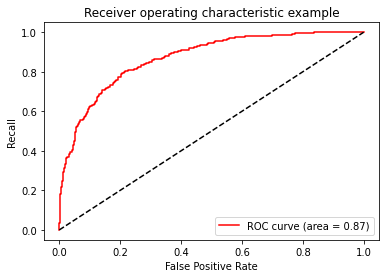

In [78]:

FPR, Recall, thresholds = ROC(Ytest,clf.decision_function(Xtest),pos_label=1)
area = roc_auc_score(Ytest,clf.decision_function(Xtest))

plt.figure()
plt.plot(FPR, Recall, color='red',
label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [79]:
maxindex = (Recall - FPR).tolist().index(max(Recall - FPR))
thresholds[maxindex]

-0.09027758630126459

In [80]:
from sklearn.metrics import accuracy_score as AC

times = time()
clf = SVC(kernel = "linear",C=3.1663157894736838,cache_size = 5000
        ,class_weight = "balanced"
        ).fit(Xtrain, Ytrain)

prob = pd.DataFrame(clf.decision_function(Xtest))
prob.loc[prob.iloc[:,0] >= thresholds[maxindex],"y_pred"]=1
prob.loc[prob.iloc[:,0] < thresholds[maxindex],"y_pred"]=0
prob.loc[:,"y_pred"].isnull().sum()

#检查模型本身的准确度
score = AC(Ytest,prob.loc[:,"y_pred"].values)
recall = recall_score(Ytest, prob.loc[:,"y_pred"])

print("testing accuracy %f,recall is %f" % (score,recall))
print(datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f"))

c:\Users\HP\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


testing accuracy 0.790000,recall is 0.804665
00:31:511235


反而还不如我们不调整时的效果好。可见，如果我们追求平衡，那SVC本身的结果就已经非常接近最优结果了。调节阈值，调节参数C和调节class_weight都不一定有效果